# Exploratory analysis: spot detection

## Overview
In this activity, we will perform spot detection on some in situ sequencing data
([Feldman and Singh et al., Cell, 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)31067-0s)).
In doing so, we will combine methods from [scipy](https://www.scipy.org/) and
[scikit-image](https://scikit-image.org/). The goal is to familiarize you with
performing analysis that integrates the scientific python ecosystem and napari.
This notebook also serves as the basis and motivation for the next notebook: [From workflow to widget: customizing napari](spot_detection_functions).

## Data source

The data were downloaded from the
[OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

## Next steps

Following this activity, we will use the workflow generated in this activity to
create a napari spot detection widget or even plugin.

## `Nebari` and `Binder` setup

In [1]:
# this cell is required to run these notebooks in the cloud. Make sure that you also have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ or 'NEBARI_JUPYTERHUB_SSH_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

## Screenshots
As previously, we will use the `nbscreenshot` to document our work in the notebook as we go along.
As a reminder, the usage is:

```Python
nbscreenshot(viewer)
```

## Load the data

In the cells below load the data using the scikit-image `imread()` function. For
more information about the `imread()` function, please see the [scikit-image docs](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread). We are loading two images:

- `nuclei`: an image of cell nuclei
- `spots`: an image of in situ sequencing spots

In [2]:
from skimage import io

nuclei_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/nuclei_cropped.tif'
nuclei = io.imread(nuclei_url)

spots_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/spots_cropped.tif'
spots = io.imread(spots_url)

Alternatively, you can load the data locally, if you cloned the repository:

In [3]:
from skimage import io

nuclei_path = 'data/nuclei_cropped.tif'
nuclei = io.imread(nuclei_path)

spots_path = 'data/spots_cropped.tif'
spots = io.imread(spots_path)

## View the data

To view our data, we will create a napari viewer and then we will add the images to the viewer
via the viewer's `add_image()` method. We will also import the `nbscreenshot` utility.

In [4]:
import napari
from napari.utils import nbscreenshot

# create the napari viewer
viewer = napari.Viewer()

# add the nuclei image to the viewer
viewer.add_image(nuclei, colormap='green')

# add the spots image to the viewer
viewer.add_image(spots, colormap='magenta', blending='additive')

<Image layer 'spots' at 0x7f4da9b22350>

After loading the data, inspect it in the viewer and adjust the
layer settings to your liking (e.g., contrast limits, colormap).
You can pan/zoom around the image by click/dragging to pan and scrolling with your
mousewheel or trackpad to zoom.

```{tip}
You can adjust a layer's opacity to see the change how much you see of the
layers that are "under" it.
```
For example, for better contrast you could choose an inverted colormap and minimum blending.

In [5]:
viewer.layers['nuclei'].colormap = 'I Forest'
viewer.layers['nuclei'].blending = 'minimum'
viewer.layers['spots'].colormap = 'I Orange'
viewer.layers['spots'].blending = 'minimum'

Once you are satisfied, you can print the output of any manual changes and then take a screenshot of the viewer.

In [6]:
# example of printing the nuclei layer visualization params
print('Colormap: ', viewer.layers['nuclei'].colormap.name)
print('Contrast limits: ', viewer.layers['nuclei'].contrast_limits)
print('Opacity: ', viewer.layers['nuclei'].opacity)
print('Blending: ', viewer.layers['nuclei'].blending)

Colormap:  I Forest
Contrast limits:  [0.006301976274698973, 0.1730983406305313]
Opacity:  1.0
Blending:  minimum


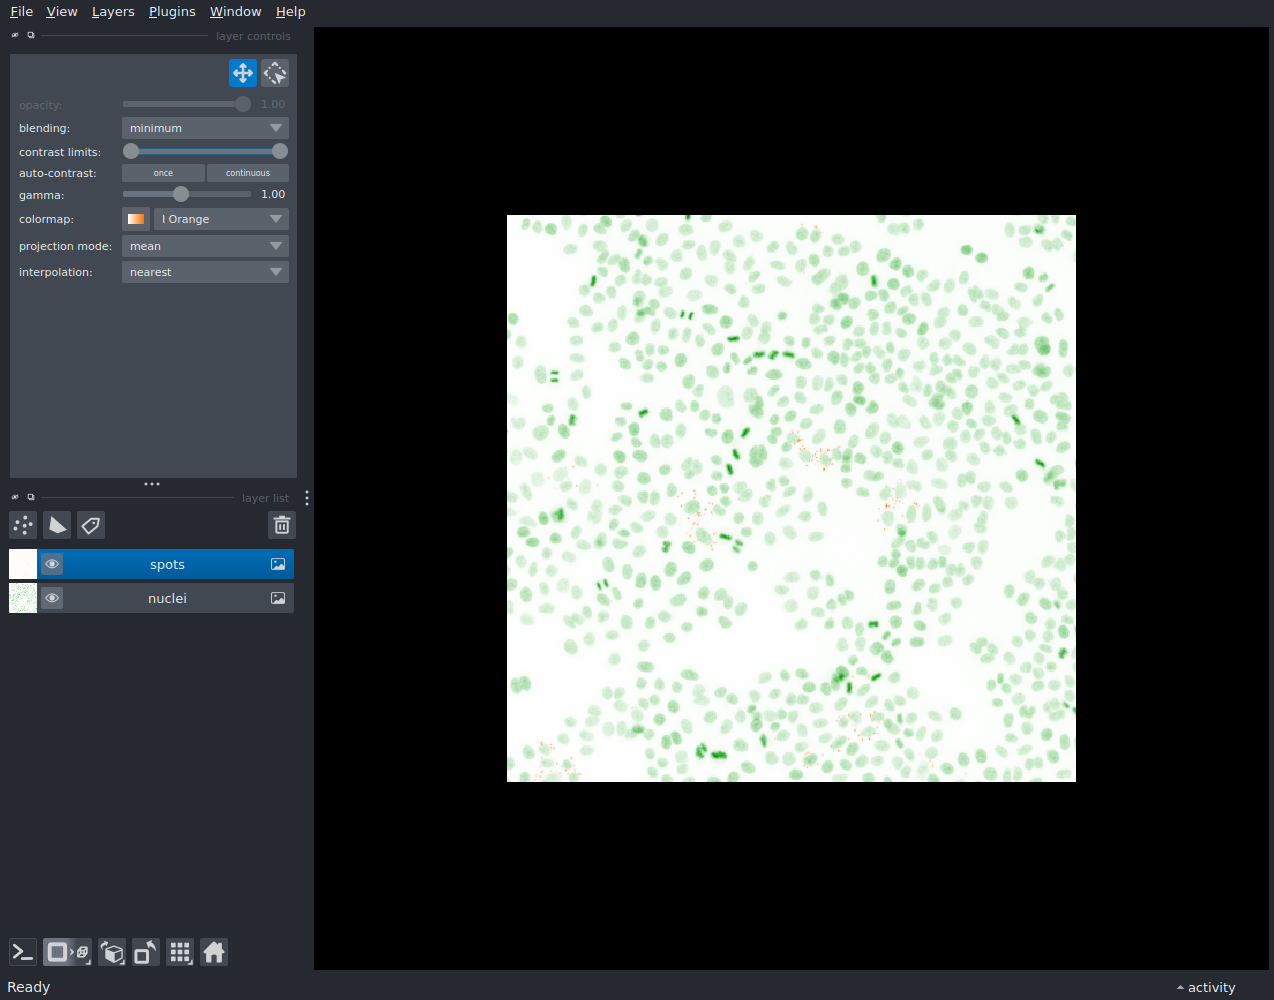

In [7]:
nbscreenshot(viewer)

## Create an image filter

If you look carefully at the `spots` layer, you will notice that it contains background and
autofluorescence from the cells. It may help to just look at the single channel.

In [8]:
viewer.layers['nuclei'].visible = False

To improve spot detection, we will apply a high pass filter to improve the contrast of the spots.

A simple way to achieve this is to:
1. blur the image with a Gaussian, which removes high-frequency information (small features, including
our spots)—this is why we use it for denoising.
2. subtract the blurred image from the original.

Lets try this using the `gaussian_filter` from `scipy` with a sigma of 2 px and lets clip any negative values:

In [9]:
import numpy as np
from scipy import ndimage as ndi


low_pass = ndi.gaussian_filter(spots, 2)
high_passed_spots = (spots - low_pass).clip(0)

Let's visualize both versions of the data.

In [10]:
viewer.add_image(low_pass, colormap="I Forest", blending="minimum")
viewer.add_image(high_passed_spots, colormap="I Blue", blending="minimum")

<Image layer 'high_passed_spots' at 0x7f4da09ba6d0>

Toggle the visibility of the 3 spots layers to get a better sense of the effect of our filter.
Let's hide the `low_pass` and take a screenshot for documentation.

In [11]:
viewer.layers['low_pass'].visible = False

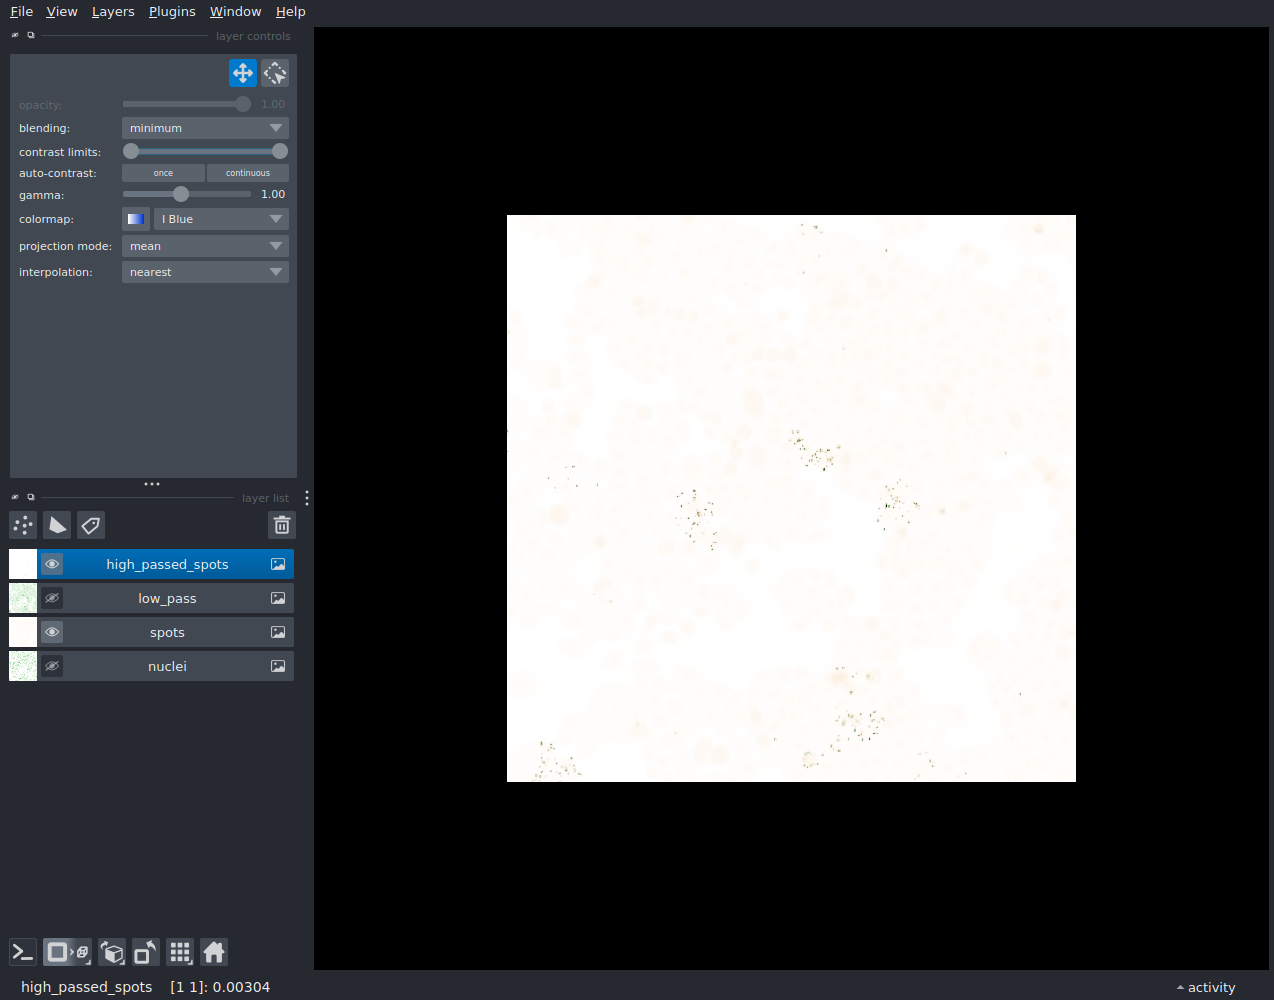

In [12]:
nbscreenshot(viewer)

## Detect spots

Next, we will use one of the blob detection algorithms from scikit-image to
perform the blob detection.

```{tip}
- See the [blob detection tutorial from scikit-image](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html). We recommend the [blob_log detector](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log), but feel free to experiment!
- See the "Note" from the blob_log docs: "The radius of each blob is approximately $\sqrt{2}\sigma$ for a 2-D image"
```

In [13]:
from skimage.feature import blob_log

# detect the spots on the filtered image
blobs_log = blob_log(
    high_passed_spots, max_sigma=3,
    threshold=None,  # use a relative threshold instead
    threshold_rel=0.2)

# convert the output of the blob detector to the
# desired points_coords and sizes arrays
# (see the docstring for details)
spot_coords = blobs_log[:, 0:2]
spot_sizes = 2 * np.sqrt(2) * blobs_log[:, 2]

To visualize the results, add the spots to the viewer as a
[Points layer](https://napari.org/stable/tutorials/fundamentals/points.html). If you
would like to see an example of using a points layer, see
[this example](https://napari.org/gallery/add_points.html).

In [14]:
# add the detected spots to the viewer as a Points layer
viewer.add_points(spot_coords, size=spot_sizes)

<Points layer 'spot_coords' at 0x7f4da879dd90>

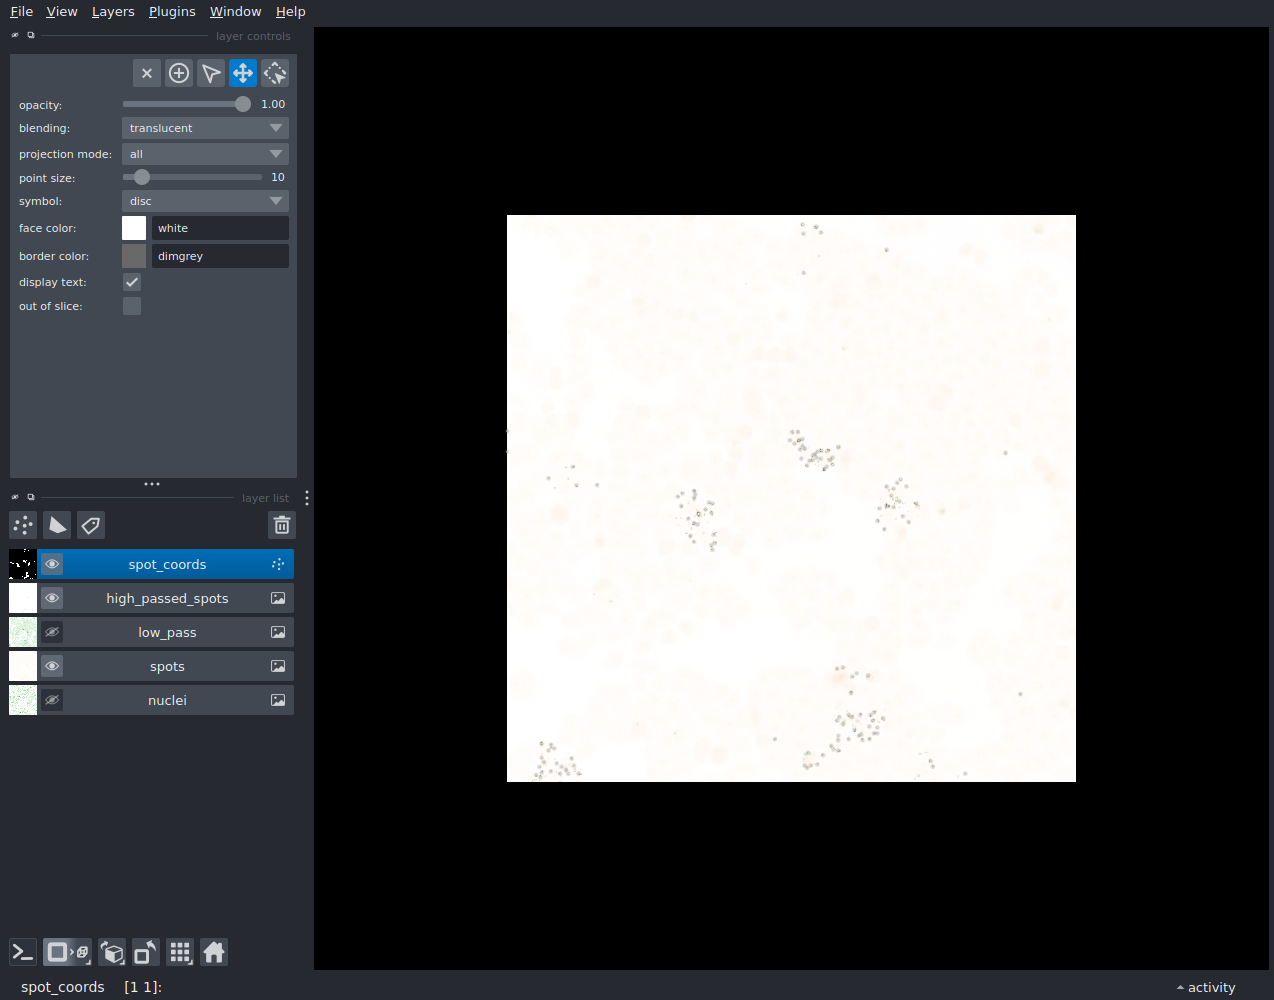

In [15]:
nbscreenshot(viewer)

Let's zoom in for a better look. You can explore interactively in the viewer and then you can explicitly
set the center of the field of view and the zoom factor.

In [16]:
viewer.camera.center = (200, 270)
viewer.camera.zoom = 8

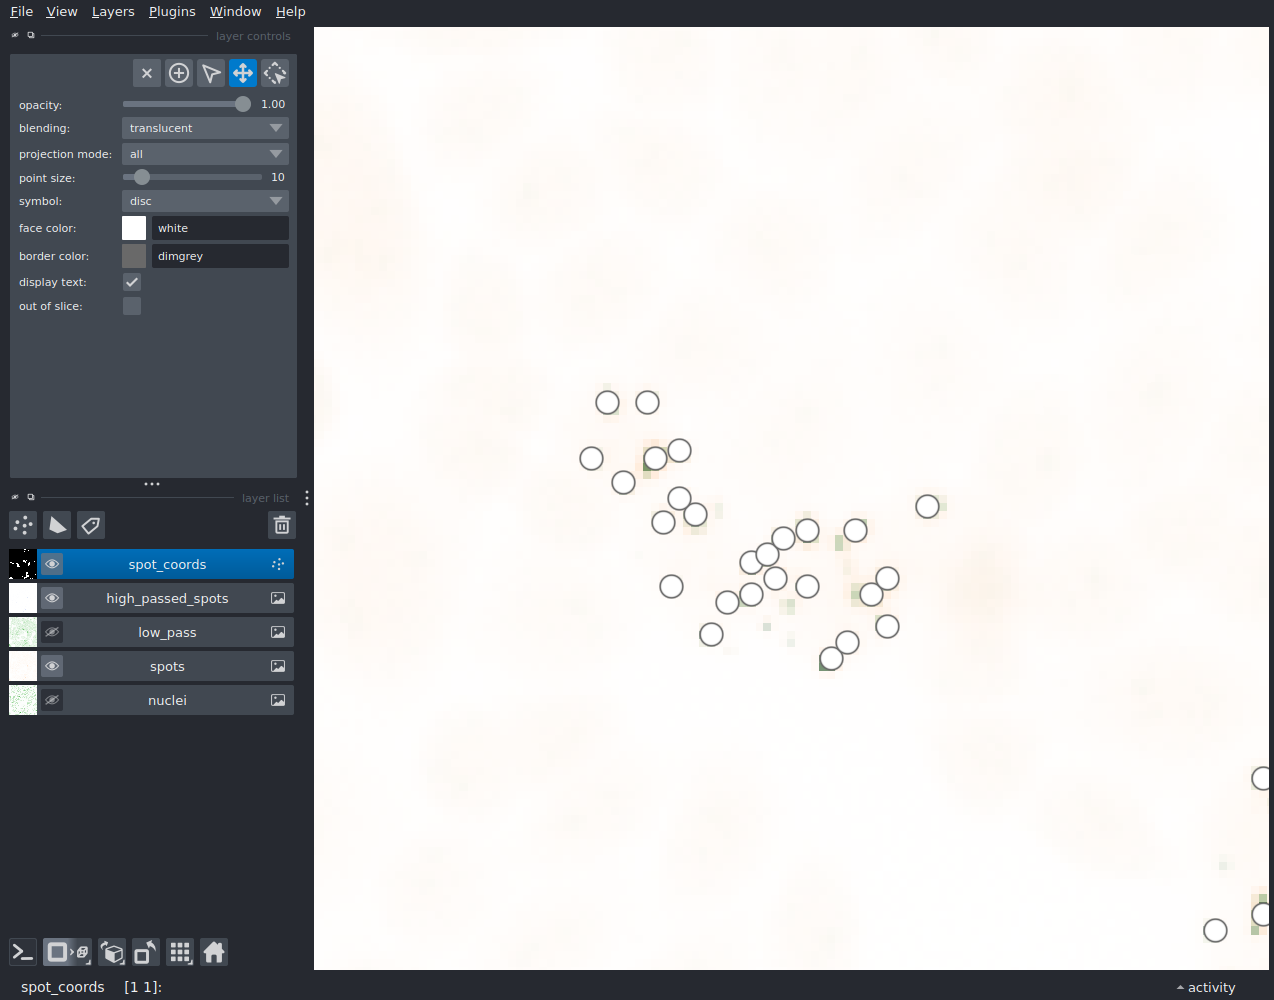

In [17]:
nbscreenshot(viewer)

## Optional: using Points layer `features`

`features` is a table associated with a Points layer that can store additional data associated with
a data point. It has one row per data element (Point) and one column per feature. This would enable you
to add other attributes like `volume` or `maximum-intensity` should you calculate those for each cell.
Importantly, napari can not only display the values of associated features in the status bar, but
also use them for styling, e.g. for `face_color`. For more information, see the
[Points layer guide](https://napari.org/stable/howtos/layers/points.html#using-the-points-features-table),
[the Points annotation tutorial](https://napari.org/stable/tutorials/annotation/annotate_points.html)
or the ["Add points with features" Gallery example](https://napari.org/stable/gallery/add_points_with_features.html#sphx-glr-gallery-add-points-with-features-py).



Let's use the `features` dictionary to store the intensity value of the image at the coordinate of point
and then we can encode the color of the point marker using that value.

First let's get an array of the pixel values of the original data array at the coordinates of our detected
points.

In [18]:
# convert coordinates into a tuple that can be used to index the image data
tuple_of_spots_as_indexes = tuple(np.round(spot_coords).astype(int).T)
intensities = viewer.layers['spots'].data[tuple_of_spots_as_indexes]

Now we will set the `features` table of our Points layer—we could have done this when we constructed the layer.

In [19]:
viewer.layers['spot_coords'].features = {'intensity': intensities}

Now when you mouseover a point, you should see the corresponding intensity value in the status bar.
Next let's hook up the coloring to color the Points by intensity.

In [20]:
viewer.layers['spot_coords'].face_color = 'intensity'
viewer.layers['spot_coords'].face_colormap = 'viridis'
viewer.layers['spot_coords'].face_color_mode = 'colormap'
viewer.layers['spot_coords'].refresh_colors()

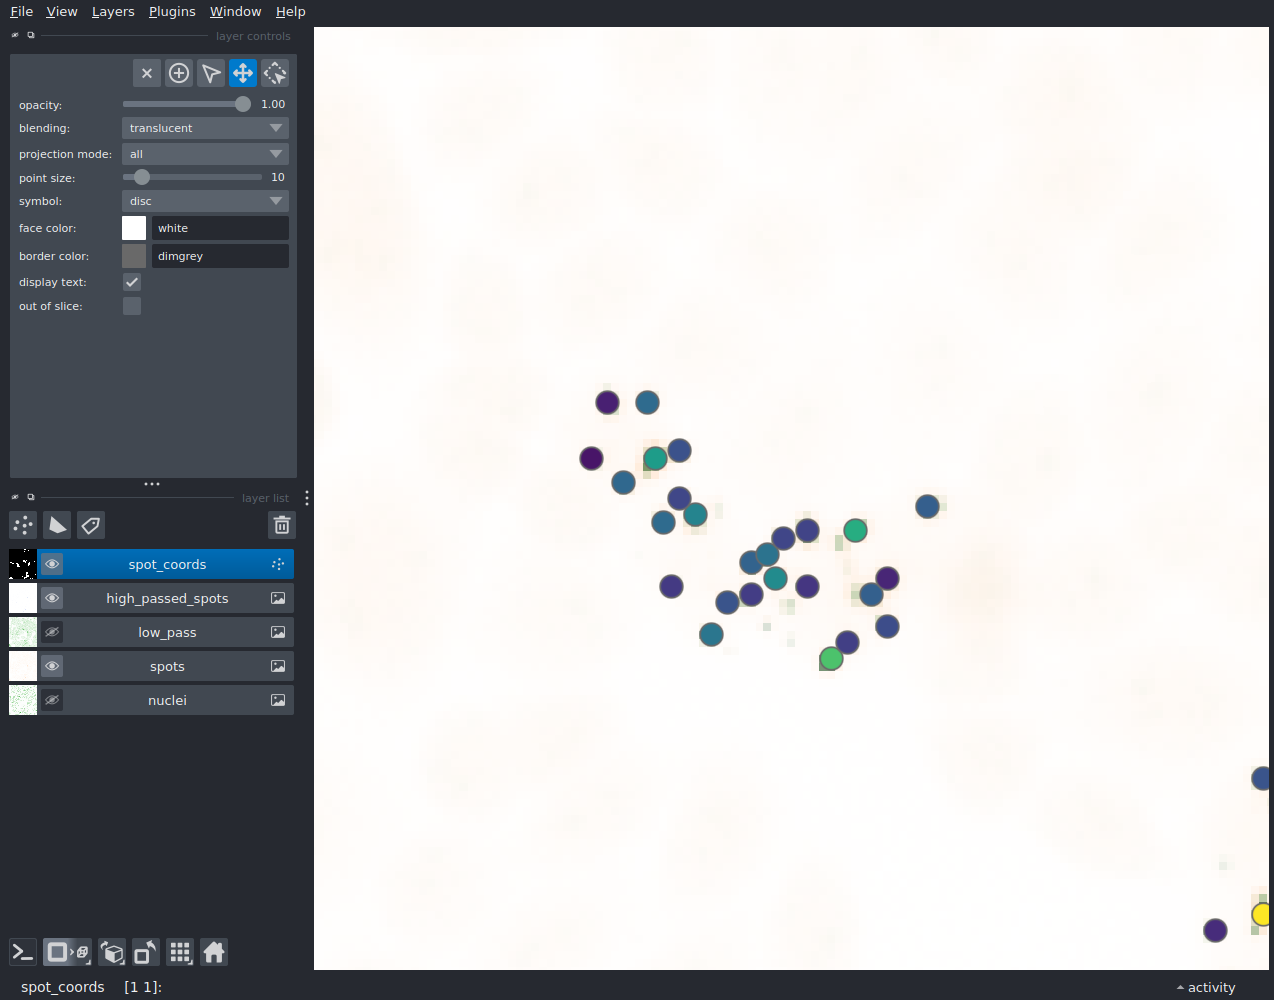

In [21]:
nbscreenshot(viewer)

## Conclusion
In this activity, we have developed done the exploratory analysis for spot detection
using a combination of Jupyter notebook, scipy, scikit-image, and napari. In the
next activity, we will convert this workflow into a spot detection function to make
it easier to explore the effect of parameters. Then, we will turn that into a napari widget
using `magicgui`.